In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_s_curve
import torch

shape of moons: (10000, 2)


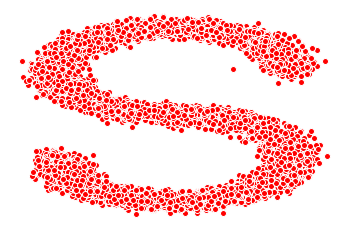

In [2]:
s_curve, _ = make_s_curve(10**4, noise = 0.1)
s_curve = s_curve[:, [0, 2]]/10.0

print('shape of moons:', np.shape(s_curve))

data = s_curve.T

fig, ax = plt.subplots()
ax.scatter(*data, color = 'red', edgecolor='white')

ax.axis('off')

dataset = torch.Tensor(s_curve).float()

In [3]:
num_steps = 100

betas = torch.linspace(-6, 6, num_steps)
betas = torch.sigmoid(betas) * (0.5e-2 - 1e-5) + 1e-5

alphas = 1 - betas
alphas_prod = torch.cumprod(alphas, 0)
alphas_prod_p = torch.cat([torch.tensor([1]).float(), alphas_prod[:-1]], 0)
alphas_bar_sqrt = torch.sqrt(alphas_prod)
one_minus_alphas_bar_log = torch.log(1 - alphas_prod)
one_minus_alphas_bar_sqrt = torch.sqrt(1-alphas_prod)

assert alphas.shape ==alphas_prod.shape==alphas_prod_p.shape==\
alphas_bar_sqrt.shape == one_minus_alphas_bar_log.shape\
==one_minus_alphas_bar_sqrt.shape
print('all the same shape:', betas.shape)

all the same shape: torch.Size([100])


In [4]:
def q_x(x_0,t):
    noise = torch.randn_like(x_0)
    alphas_t = alphas_bar_sqrt[t]
    alphas_l_m_t = one_minus_alphas_bar_sqrt[t]
    return (alphas_t * x_0 + alphas_l_m_t * noise)

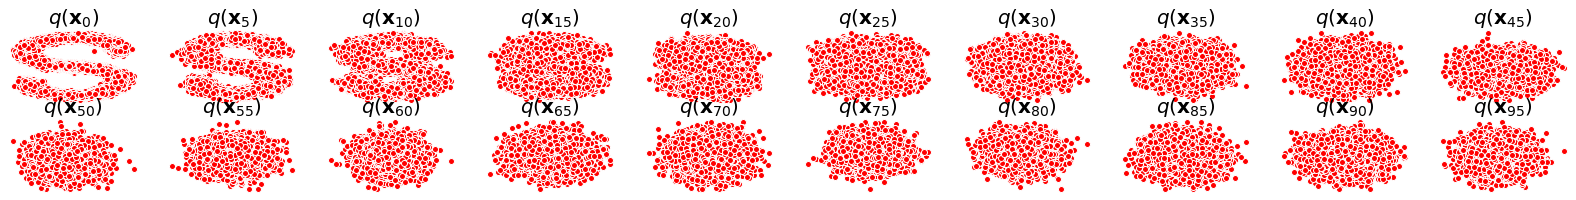

In [5]:
num_shows = 20
fig, axs = plt.subplots(2, 10, figsize = (28,3))
plt.rc('text',color='blue')

for i in range(num_shows):
    j = i//10
    k = i%10
    q_i = q_x(dataset,torch.tensor([i*num_steps//num_shows]))
    axs[j,k].scatter(q_i[:,0], q_i[:,1],color='red',edgecolor='white')
    
    axs[j,k].set_axis_off()
    axs[j,k].set_title('$q(\mathbf{x}_{'+str(i*num_steps//num_shows)+'})$',fontsize = 20)

In [6]:
import torch
import torch.nn as nn

class MLPDiffusion(nn.Module):
    
    def __init__(self, n_steps, num_units = 128):
        super(MLPDiffusion,self).__init__()
        
        self.linears = nn.ModuleList(
        [
            nn.Linear(2, num_units),
            nn.GELU(),
            nn.Linear(num_units,num_units),
            nn.GELU(),
            nn.Linear(num_units,num_units),
            nn.GELU(),
            nn.Linear(num_units,2),
        ])
        
        self.step_embeddings = nn.ModuleList(
            [
                nn.Embedding(n_steps, num_units),
                nn.Embedding(n_steps, num_units),
                nn.Embedding(n_steps, num_units),
            ])
    
    def forward(self, x, t):
        for idx, embedding_layer in enumerate(self.step_embeddings):
            t_embedding = embedding_layer(t)
            x = self.linears[2*idx](x)
            x += t_embedding
            x = self.linears[2*idx+1](x)
        
        x = self.linears[-1](x)
        return x

In [7]:
def diffusion_loss(model, x_0, alphas_bar_sqrt, one_minus_alphas_bar_sqrt, n_steps):
    batch_size = x_0.shape[0]
    t = torch.randint(0, n_steps, size=(batch_size//2,))
    t = torch.cat([t, n_steps-1-t], dim = 0)
    t = t.unsqueeze(-1)
    
    a = alphas_bar_sqrt[t]
    
    am1 = one_minus_alphas_bar_sqrt[t]
    
    e = torch.randn_like(x_0)
    
    x = x_0*a + e*am1
    
    output = model(x, t.squeeze(-1))
    
    return (e - output).square().mean()

In [8]:
def p_sample_loop(model,shape, n_steps, betas, one_minus_alphas_bar_sqrt):
    
    cur_x = torch.randn(shape)
    x_seq = [cur_x]
    for i in reversed(range(n_steps)):
        cur_x = p_sample(model, cur_x, i, betas, one_minus_alphas_bar_sqrt)
        x_seq.append(cur_x)
    return x_seq

def p_sample(model, x, t, betas, one_minus_alphas_bar_sqrt):
    t = torch.tensor([t])
    
    coeff = betas[t] / one_minus_alphas_bar_sqrt[t]
    
    eps_theta = model(x ,t)
    
    mean = (1 / (1-betas[t]).sqrt()) * (x - (coeff * eps_theta))
    
    z = torch.randn_like(x)
    
    sigma_t = betas[t].sqrt()
    
    sample = mean + sigma_t * z
    
    return sample
    

tensor(0.4169, device='cuda:0', grad_fn=<ToCopyBackward0>)
tensor(0.4999, device='cuda:0', grad_fn=<ToCopyBackward0>)
tensor(0.2423, device='cuda:0', grad_fn=<ToCopyBackward0>)
tensor(0.4553, device='cuda:0', grad_fn=<ToCopyBackward0>)
tensor(0.4795, device='cuda:0', grad_fn=<ToCopyBackward0>)
tensor(0.2520, device='cuda:0', grad_fn=<ToCopyBackward0>)
tensor(0.2025, device='cuda:0', grad_fn=<ToCopyBackward0>)
tensor(0.2192, device='cuda:0', grad_fn=<ToCopyBackward0>)
tensor(0.1818, device='cuda:0', grad_fn=<ToCopyBackward0>)
tensor(0.5274, device='cuda:0', grad_fn=<ToCopyBackward0>)
tensor(0.3024, device='cuda:0', grad_fn=<ToCopyBackward0>)
tensor(0.7395, device='cuda:0', grad_fn=<ToCopyBackward0>)
tensor(0.2126, device='cuda:0', grad_fn=<ToCopyBackward0>)
tensor(0.3663, device='cuda:0', grad_fn=<ToCopyBackward0>)
tensor(0.2562, device='cuda:0', grad_fn=<ToCopyBackward0>)
tensor(0.3340, device='cuda:0', grad_fn=<ToCopyBackward0>)
tensor(0.3604, device='cuda:0', grad_fn=<ToCopyBackward0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor(0.1083, device='cuda:0', grad_fn=<ToCopyBackward0>)
tensor(0.1749, device='cuda:0', grad_fn=<ToCopyBackward0>)
tensor(0.4798, device='cuda:0', grad_fn=<ToCopyBackward0>)
tensor(0.5032, device='cuda:0', grad_fn=<ToCopyBackward0>)
tensor(0.3449, device='cuda:0', grad_fn=<ToCopyBackward0>)
tensor(0.5095, device='cuda:0', grad_fn=<ToCopyBackward0>)
tensor(0.3713, device='cuda:0', grad_fn=<ToCopyBackward0>)
tensor(0.5837, device='cuda:0', grad_fn=<ToCopyBackward0>)
tensor(0.3770, device='cuda:0', grad_fn=<ToCopyBackward0>)
tensor(0.1212, device='cuda:0', grad_fn=<ToCopyBackward0>)
tensor(0.4416, device='cuda:0', grad_fn=<ToCopyBackward0>)
tensor(0.2502, device='cuda:0', grad_fn=<ToCopyBackward0>)
tensor(0.2138, device='cuda:0', grad_fn=<ToCopyBackward0>)
tensor(0.2179, device='cuda:0', grad_fn=<ToCopyBackward0>)
tensor(0.2714, device='cuda:0', grad_fn=<ToCopyBackward0>)
tensor(0.3465, device='cuda:0', grad_fn=<ToCopyBackward0>)
tensor(0.2980, device='cuda:0', grad_fn=<ToCopyBackward0

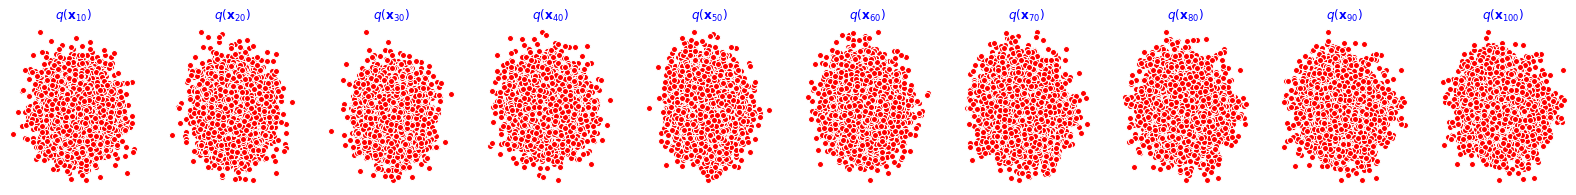

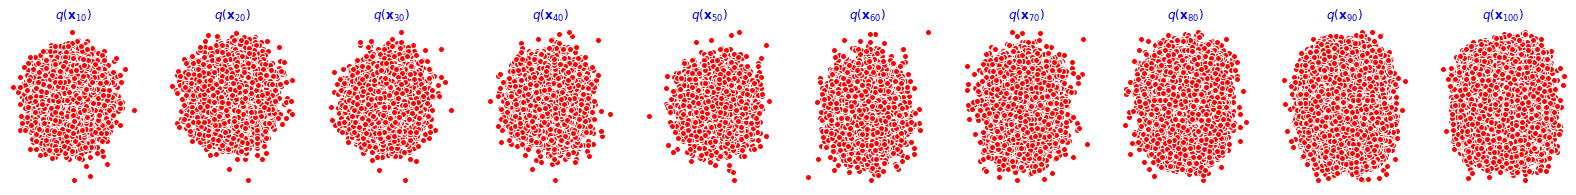

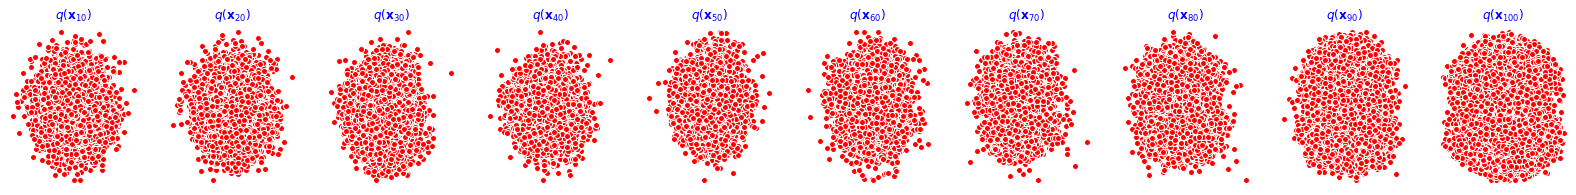

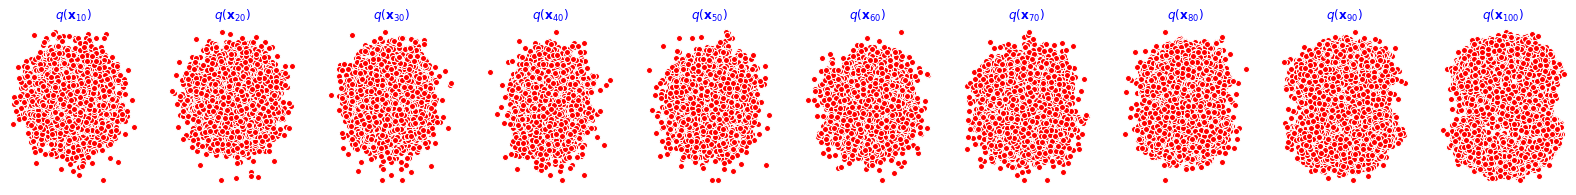

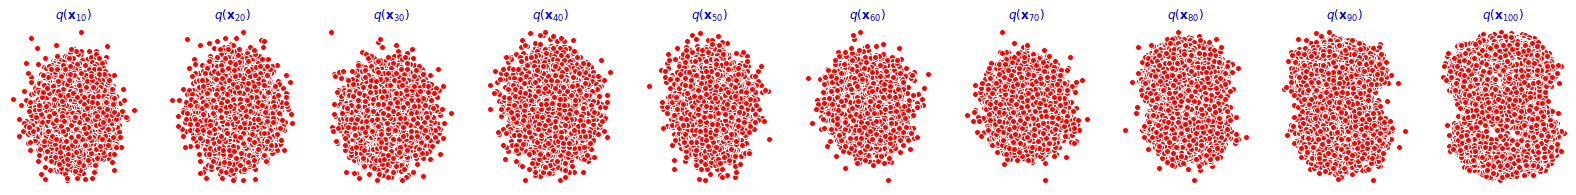

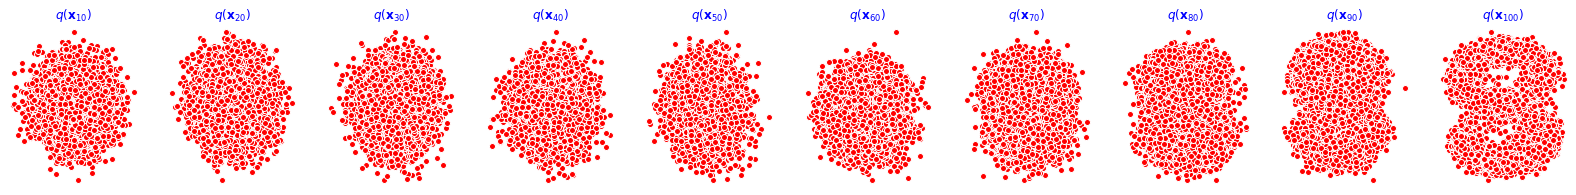

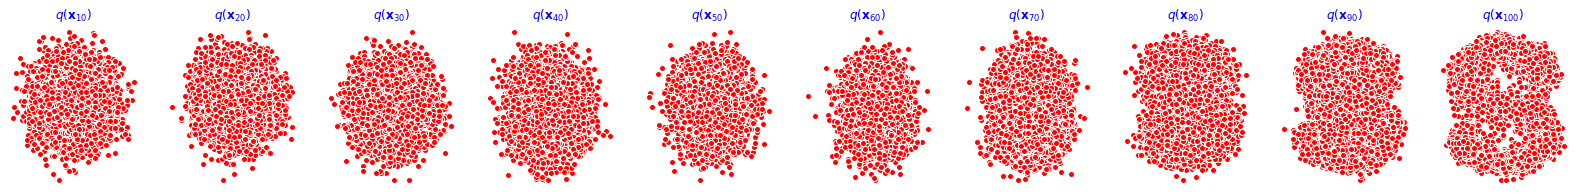

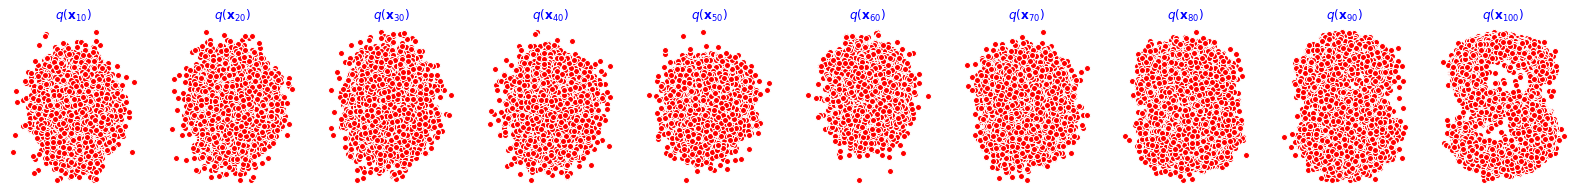

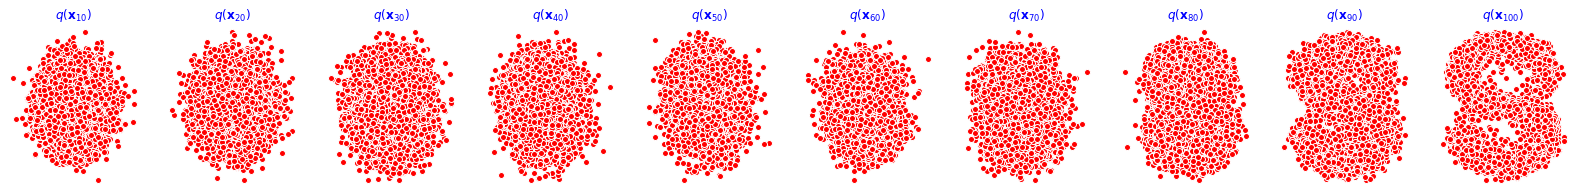

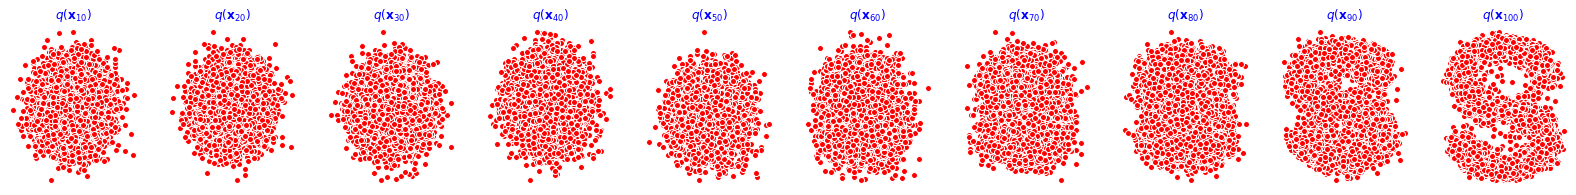

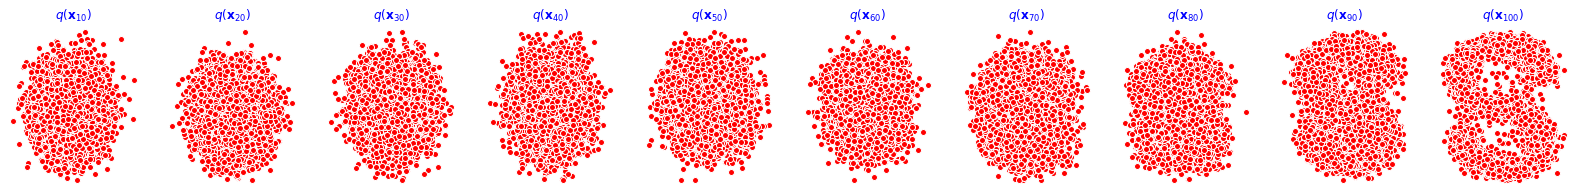

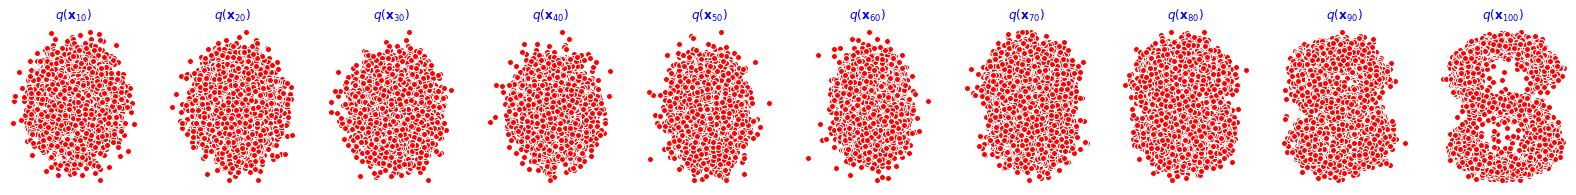

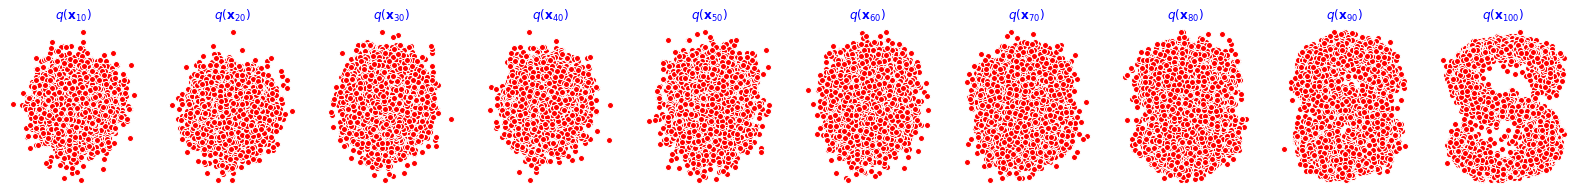

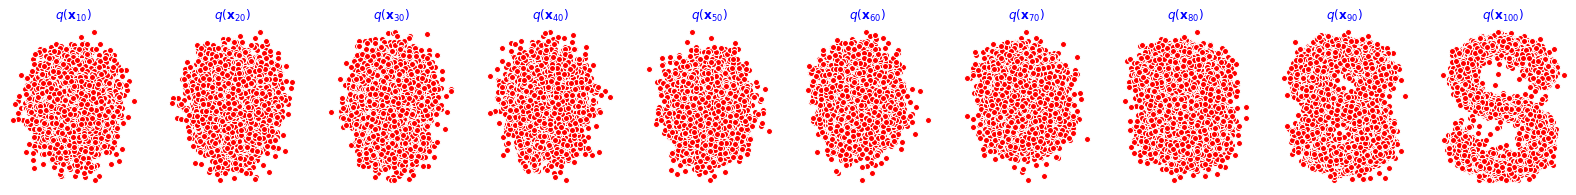

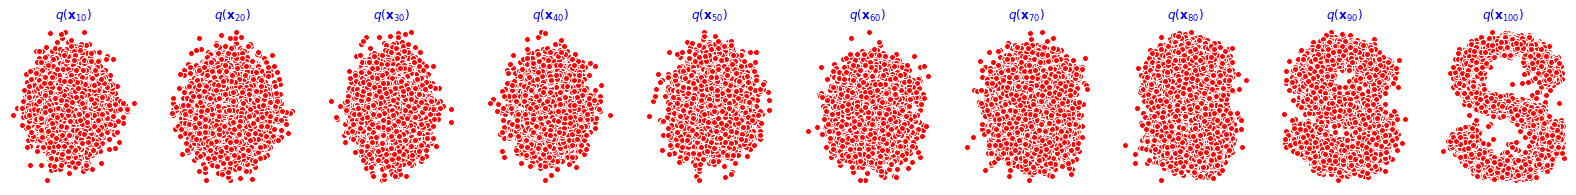

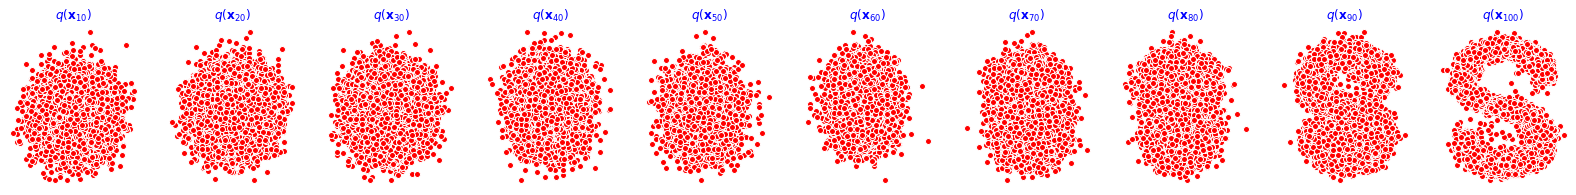

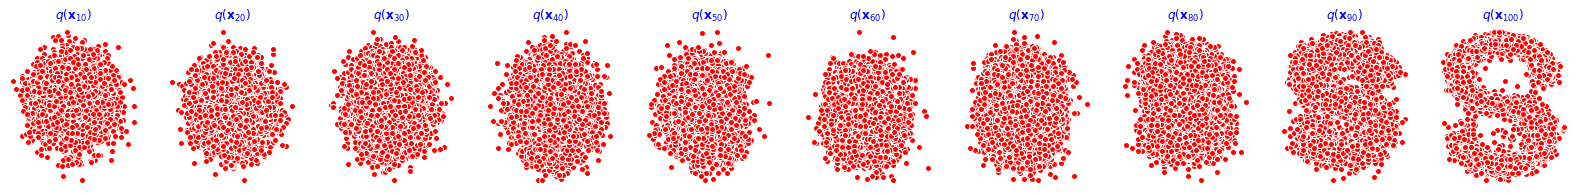

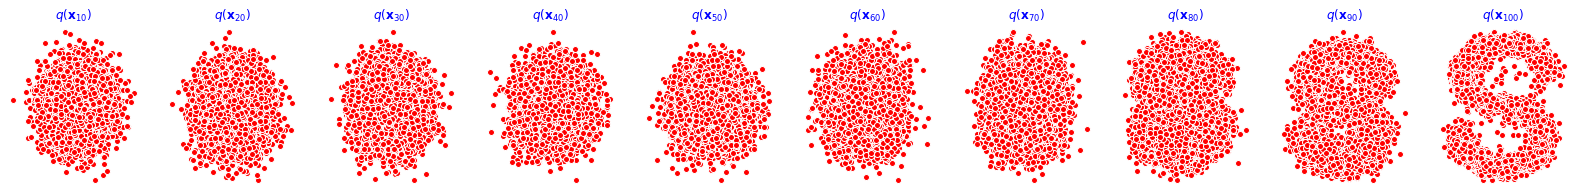

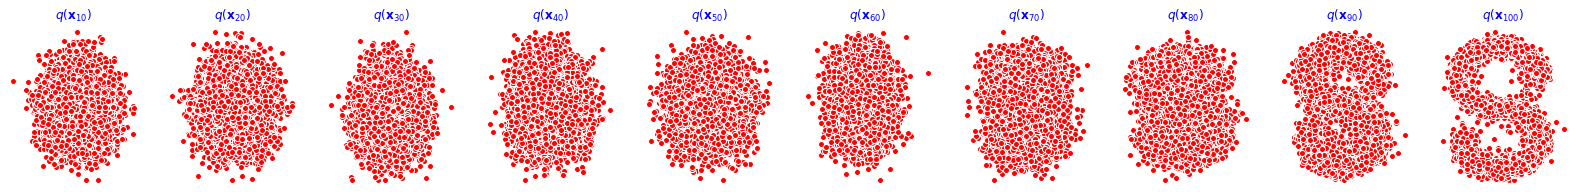

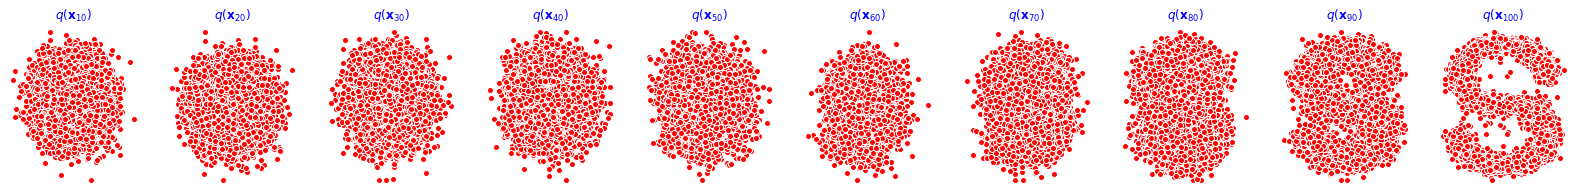

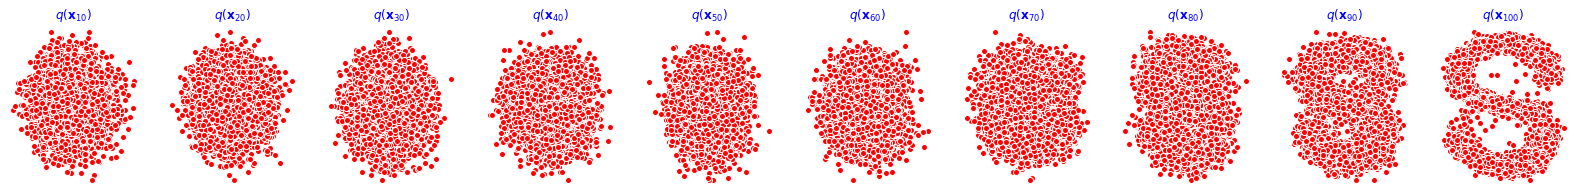

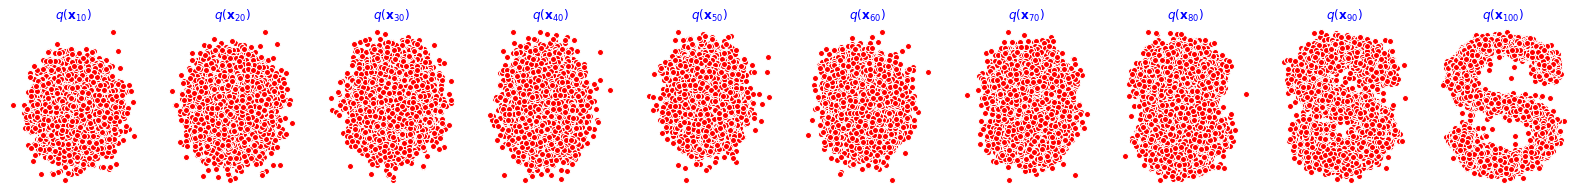

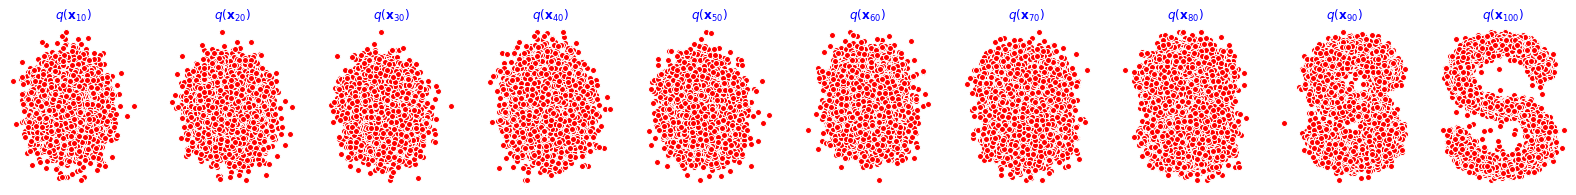

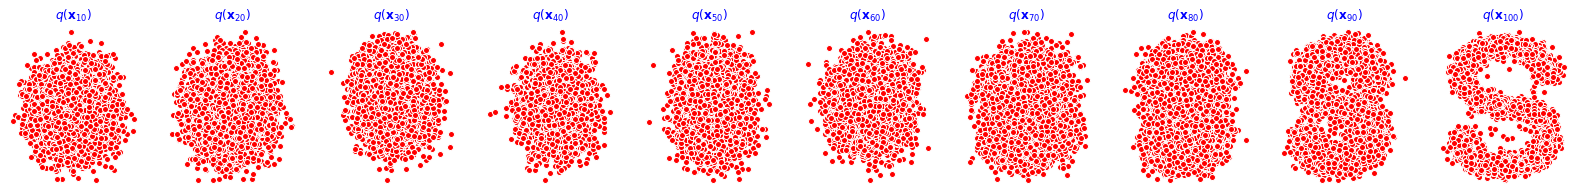

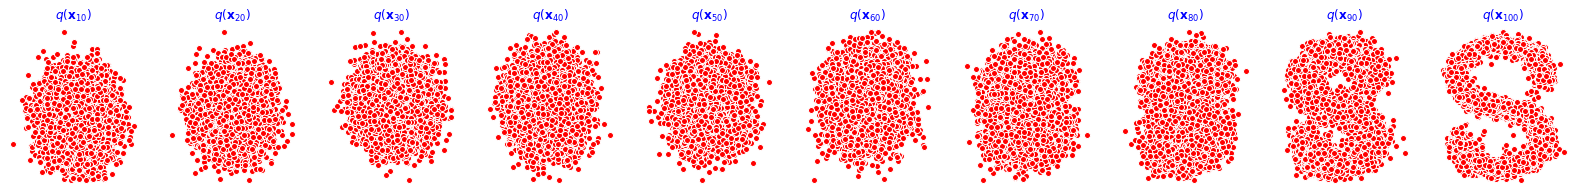

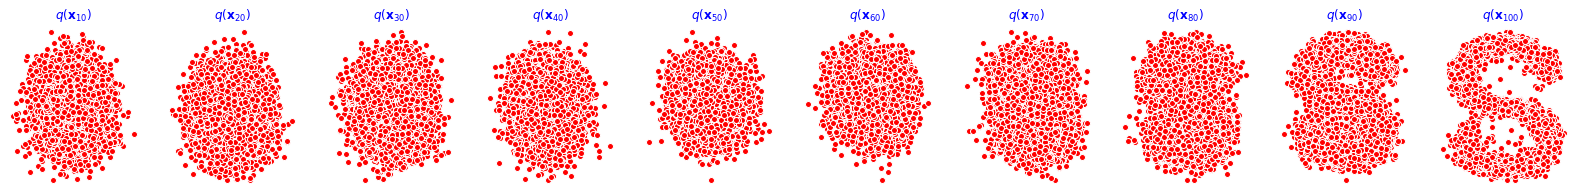

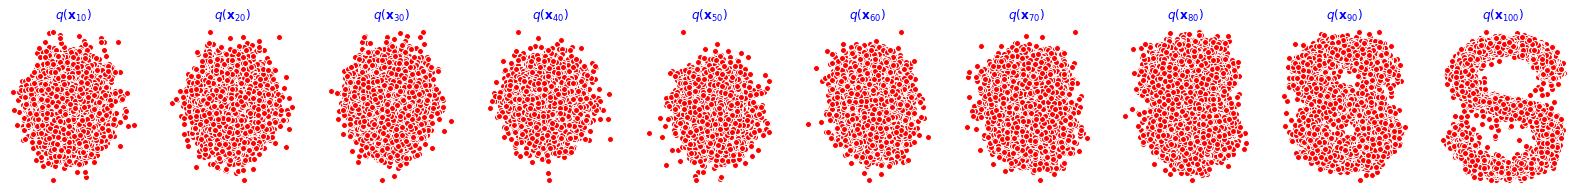

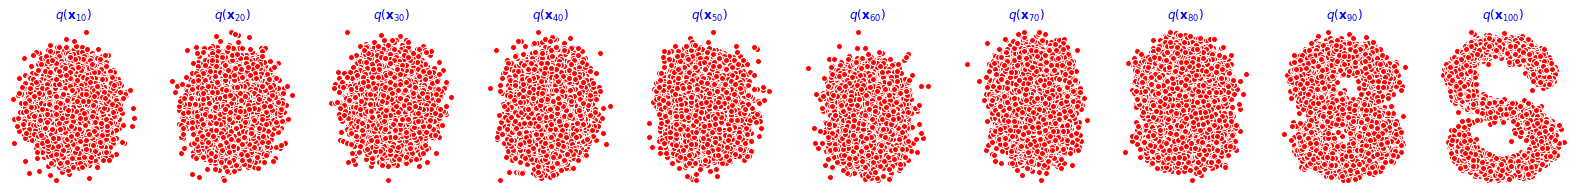

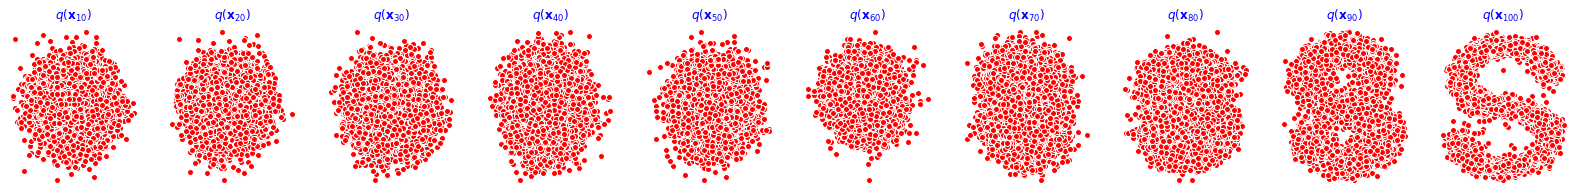

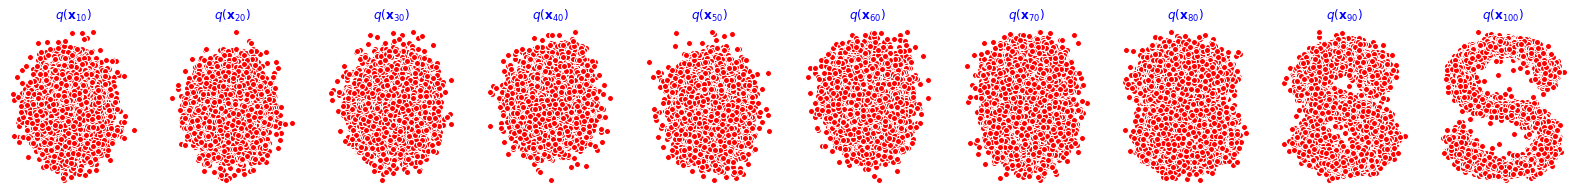

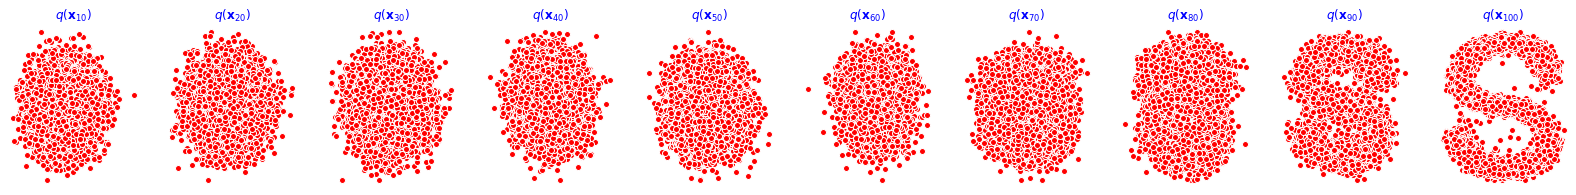

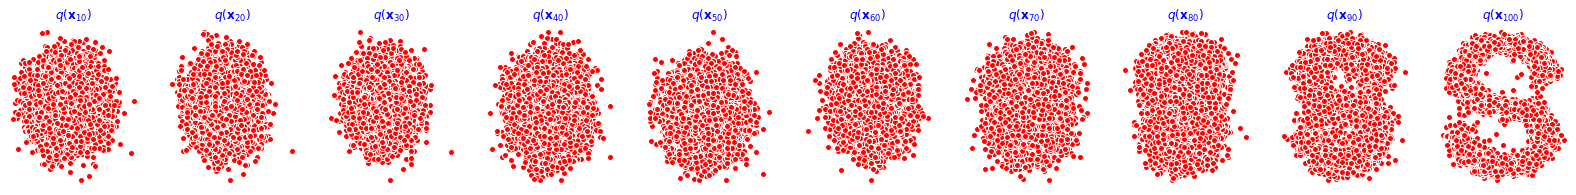

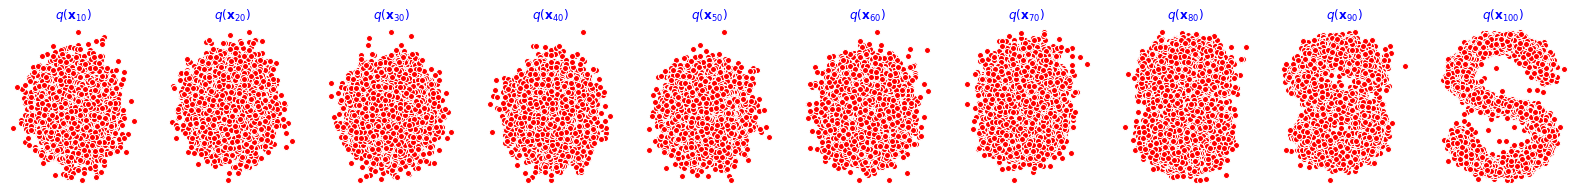

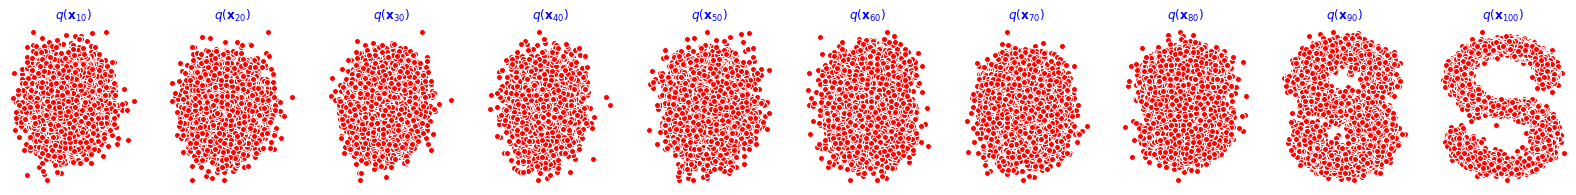

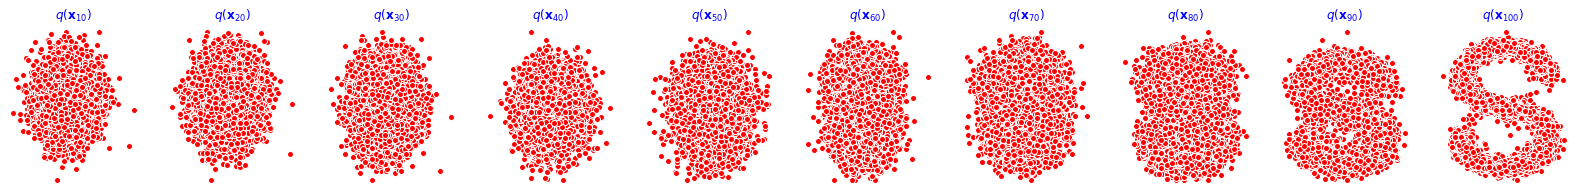

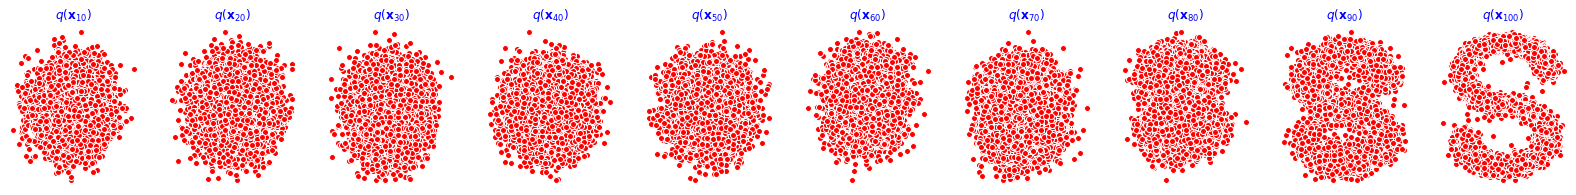

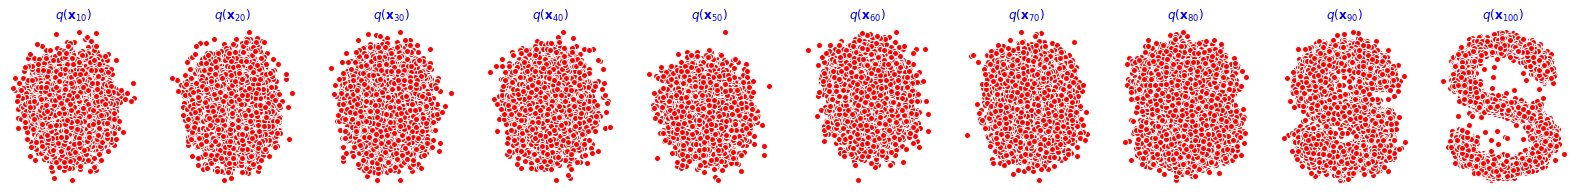

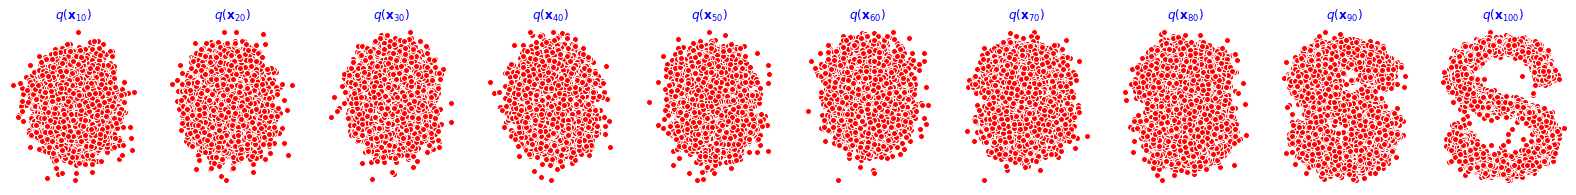

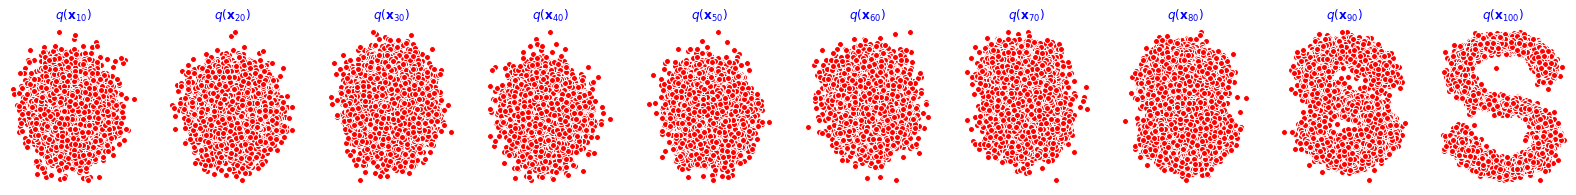

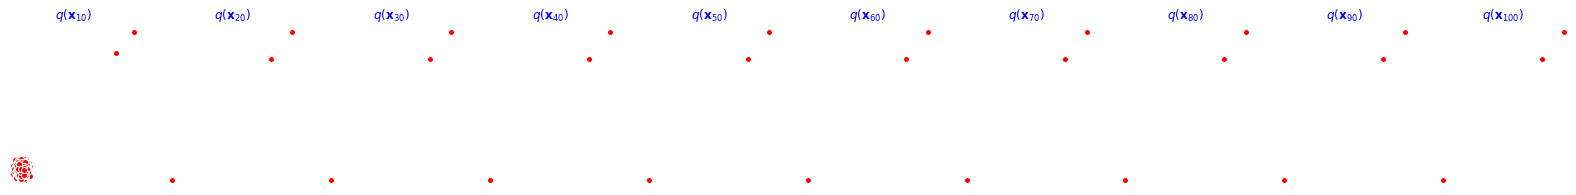

In [9]:
seed = 1234

batch_size = 128

dataloader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, shuffle =True)
num_epoch = 4000
plt.rc('text',color ='blue')

model = MLPDiffusion(num_steps)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)



for t in range(num_epoch):
    for idx, batch_x in enumerate(dataloader):
        loss = diffusion_loss(model, batch_x, alphas_bar_sqrt, one_minus_alphas_bar_sqrt, num_steps)
        loss = loss.cuda()
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
        optimizer.step()
    
    if (t%100 == 0):
        print(loss)
        x_seq = p_sample_loop(model, dataset.shape, num_steps, betas, one_minus_alphas_bar_sqrt)
        
        fig, axs = plt.subplots(1,10,figsize= (28,3))
        for i in range(1,11):
            cur_x = x_seq[i * 10].detach()
            axs[i-1].scatter(cur_x[:, 0], cur_x[:, 1], color = 'red', edgecolor = 'white')
            axs[i-1].set_axis_off()
            axs[i-1].set_title('$q(\mathbf{x}_{'+str(i*10)+'})$')